In [1]:
import numpy as np
import openpyxl.utils
%matplotlib inline

import torch
import pylab as plt
from munch import munchify
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from tqdm import tqdm
# from preprocessing.s02_create_dataset import load_cores_h5py

In [2]:
# project root
project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'

args = {}

# yaml configuration file location
args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
# experiment location to load
args['exp_suffix'] = '_Patch/1e-4_onecycleNovo_fr.4numgrad6----res10_srs26_vs.4_edl-mse-anl50-thr.2_ep120'
# args['exp_suffix'] = '_Patch/1e-4_onecycleNovo_fr.4numgrad6----inv.7train.4test_res10_UVA400_srs26_vs.4'
# args['exp_suffix'] = '_Patch/1e-4_onecycleNovo_fr.4numgrad6----res10_UVA400_srs26_vs.4'

# opt is a dictionary which contains all configurations
with open(args['config']) as f:
    opt = yaml.load(f, Loader)
opt.update(args)
opt = munchify(opt)
opt.project_root = project_root
opt = setup_directories(opt)

num_workers = 0
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# creating the neural network
net = construct_network(device, opt)
net = net[0]()

# loading the saved weights to it
suffix = '_1'
net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))

<All keys matched successfully>

In [4]:
# datafile to load the data. This cell and the next cell are just for having some sense of how to feed data.
# Please load your own data and make them similar to the shape of data in dataset.
data_file = '/'.join([opt.data_source.data_root, opt.data_source.test_set])
print('loading data...')
input_data = load_matlab(data_file)
print('loading done!')

loading data...
loading done!


In [5]:
input_data = dataset.preprocess(input_data, norm=opt.normalize_input, shffl_patients=False, signal_split=False,
                        split_rs=opt.split_random_state, val_size=opt.val_size, augment=opt.aug_type != 'none')

C:\Users\Mahdi\Desktop\Summer21\RA\Codes\Minh_Mahdi_mod\prostate_cancer_classification\utils\dataset.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  input_data[f'data_{set_name}'] = np.array(input_data[f'data_{set_name}'])


In [42]:
# This function takes in net, device, and pair of (input, label, location) and produces output
# This is used in the next cell
def drop_eval(net, x_raw, n_batch, T_samples):
    pred_list, unc_list = [], []
    for i in range(T_samples):
        out1 = net(x_raw, n_batch)
        pred = F.softmax(out1, dim=1)
        pred_list.append(torch.unsqueeze(pred, dim=0))
    pred_mean = torch.cat(pred_list, 0).mean(dim=0)
    confidence,_ = torch.max(pred_mean, dim=1)
    unc = 1. - confidence
    return pred_mean, unc


def predict(net, input_data, input_label, device, unc_method, T_samples=30, unc_thr=0.2):
    from sklearn.metrics import confusion_matrix


    # location is not important here, so we make it up randomly
    input_location = torch.ones_like(input_label)

    outputs = []
    entropic_scores = []
    uncertainty = []
    total = correct = 0

    cm = np.zeros((2,2))
    cm_unc = np.zeros((2,2))

    no_data = len(input_data)
    batch_size = 64
    no_batch = no_data//batch_size
    print('no batches and batch size:', no_batch, batch_size)
    # built-in function of class torch.utils.Dataset which sets model in evaluation mode
    # (here both evaluation and training are the same)
    net.eval()
    # apply model on test signals
    with torch.no_grad():
        for i in range(no_batch+1):
            strt = i*batch_size
            end = (i+1)*batch_size
            x_raw, y_batch, n_batch = input_data[strt:end,...], input_label[strt:end,...], input_location[strt:end,...]
            x_raw, y_batch, n_batch = x_raw.to(device), y_batch.to(device), n_batch.to(device)

            if unc_method=='dropout':
                # pred and uncertainty (1-confidence) of dropout
                pred, unc = drop_eval(net, x_raw, n_batch, T_samples)
            else:
                out1 = net(x_raw, n_batch)
                pred = F.softmax(out1, dim=1)

                alpha = F.relu(out1) + 1
                unc = 2. / torch.sum(alpha, dim=1, keepdim=True).reshape(-1)

            probabilities = pred  # torch.nn.Softmax(dim=1)(pred)
            entropies = -(probabilities * torch.log(probabilities)).sum(dim=1)
            entropic_scores.append((-entropies).cpu().numpy())

            uncertainty.append(unc.cpu().numpy())

            outputs.append(pred.cpu().numpy())
            total += y_batch.size(0)
            correct += (pred.argmax(dim=1) == torch.argmax(y_batch, dim=1)).sum().item()

            cm += confusion_matrix(y_batch.argmax(dim=1).cpu(), pred.argmax(dim=1).cpu(), labels=[0,1])
            ind_unc = unc<=unc_thr
            cm_unc += confusion_matrix((y_batch[ind_unc, ...]).argmax(dim=1).cpu(),
                                       (pred[ind_unc, ...]).argmax(dim=1).cpu(), labels=[0,1])


    tn, fp, fn, tp = cm.ravel()
    tn_unc, fp_unc, fn_unc, tp_unc = cm_unc.ravel()
    acc_sb = (tp/(tp+fn) + tn/(tn+fp))/2.0
    acc_sb_unc = (tp_unc/(tp_unc+fn_unc) + tn_unc/(tn_unc+fp_unc))/2.0

    outputs = np.concatenate(outputs)
    uncertainty = np.concatenate(uncertainty)
    entropic_scores = np.concatenate(entropic_scores)
    return outputs, uncertainty, entropic_scores, correct / total, acc_sb, acc_sb_unc

def infer_core_wise2(predictions, uncertainty, core_len, roi_coors, unc_thr, ood_scores=None):
    """
    Infer core-wise predictions based on signal-wise predictions.
    Input must be 1-D array
    :param predictions: signal-wise predictions
    :param core_len: length of each core
    :param roi_coors: pixel-wise coordinates of ROI area
    :param ood_scores:
    :return:
    """
    counter = 0
    no_uncCores = 0
    core_feat1, core_res1, core_l1, core_l2, core_l3, core_ood = [], [], [], [], [], []
    prediction_maps = []

    # find a label for each core
    for i in range(len(core_len)):
        temp = predictions[counter:(counter + core_len[i])]
        un = uncertainty[counter:(counter + core_len[i])]
        temp2 = temp[un <= unc_thr, ...]
        if len(temp2) <= np.round(0.6*core_len[i]):
            no_uncCores += 1
            core_l3.append(np.nan)
        else:
            core_l3.append(np.greater(temp2[:, 1], temp2[:, 0]).sum() / len(temp2))

        core_l1.append(np.greater(temp[:, 1], temp[:, 0]).sum() / core_len[i])
        core_l2.append(temp[:, 1].sum() / core_len[i])
        core_ood.append(ood_scores)
        counter += core_len[i]

    if no_uncCores!=0:
        print(f'no uncertain cores {no_uncCores}')
    return (core_l1, core_l2, core_l3), core_ood, prediction_maps

In [29]:
def net_interpretation2(predicted_label, patient_id, involvement, gleason_score, result_dir=None,
                       ood=None, cct=(0.2, 0.6, 1), cbt=(0, 1, 0.6), cf=(1, 0.2, 0.6),
                       current_epoch=None, set_name='Test', writer=None, scores: dict = None, threshold=0.5,
                       plotting=True,  edl=False):
    import seaborn as sns
    predicted_label_nounc = predicted_label[0]
    # in case edl is not used
    predicted_label_unc = predicted_label[1]
    pred_inv_wNan = predicted_label[1]

    if edl:
        pred_inv_wNan = predicted_label[2]
        predicted_label_unc = np.array([pred_inv_wNan[i] for i in range(len(pred_inv_wNan))
                                              if not np.isnan(pred_inv_wNan[i])])

    # predicted_label = np.array([item > 0.5 for item in predicted_label])
    true_label = np.array([item > 0 for item in involvement])

    predicted_label_th = np.array(predicted_label_nounc)
    predicted_label_th[predicted_label_th > threshold] = 1
    predicted_label_th[predicted_label_th <= threshold] = 0

    andlabels = np.logical_and(predicted_label_th, true_label)

    patients = np.unique(patient_id)
    # Invs = np.ones_like(involvement)
    Invs = involvement * 100
    gs = np.array(gleason_score)
    indx = []
    maxc = 0
    for ip in patients:
        temp = np.where(patient_id == ip)[0]
        indx.append(temp)
        maxc = max(maxc, len(temp))

    inv = np.zeros((len(patients), maxc), dtype=float)
    #    cmaps=[]

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig1, ax1 = plt.subplots()
    #todo: might overkill memory
    fig1.set_size_inches(18.5*2, 10.5*2)
    barbase = np.cumsum(np.concatenate((np.zeros((inv.shape[0], 1)), inv[:, 0:-1]), axis=1), 1)

    for i in range(maxc):
        ax1.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax1.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax1.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    # plt.savefig(f'{result_dir}/{set_name}_acc_per_core{current_epoch_str}.png')
    if plotting:
        plt.show()

    ood_sum = np.array([-_ood.sum() for _ood in ood])
    ood_normalized = ood_sum / ood_sum.sum()

    fig2 = plt.figure(2)
    ax2 = sns.scatterplot(x=involvement, y=predicted_label_nounc, size=ood_normalized, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax2)
    ax2.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax2.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax2.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax2.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax2.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax2.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax2.axis('square')
    ax2.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])
    if scores is not None:
        ax1.set_title(f'ACC: {scores["acc"]:.2f} | ACC_B: {scores["acc_b"]:.2f} '
                      f'AUC: {scores["auc"]:.2f} | SEN: {scores["sen"]:.2f} | SPE: {scores["spe"]:.2f}')
        ax2.set(title=f'Correlation Coefficient = {scores["corr"]:.3f} | MAE = {scores["mae"]:.3f}',
                xlabel='True Involvement', ylabel='Predicted Involvement'
                )
    # plt.savefig('point_cloud3.png')
    if plotting:
        plt.show()

#############################################################################################
    # new plot based on new way of finding core predictions
    predicted_label_th_unc = np.copy(np.array(pred_inv_wNan))
    predicted_label_th_unc[predicted_label_th_unc > threshold] = 1
    predicted_label_th_unc[predicted_label_th_unc <= threshold] = 0

    andlabels_unc = np.logical_and(predicted_label_th_unc, true_label)

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels_unc[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th_unc[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
        if np.isnan(pred_inv_wNan[i]):
            cmap[i] = (.9,.9,.9)

    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig3, ax3 = plt.subplots()
    fig3.set_size_inches(18.5*2, 10.5*2)

    for i in range(maxc):
        ax3.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax3.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax3.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    if plotting:
        plt.show()

    fig4 = plt.figure(4)
    inv_unc = np.array([involvement[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    ood_unc = np.array([ood_normalized[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    if len(inv_unc)==0:
        inv_unc = [1.]
        predicted_label_unc = [0.]
        ood_unc = ood_normalized[0]
    ax4 = sns.scatterplot(x=inv_unc, y=predicted_label_unc, size=ood_unc, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax4)
    ax4.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax4.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax4.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax4.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax4.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax4.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax4.axis('square')
    ax4.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])

    if plotting:
        plt.show()

    if writer:
        # img = plot_to_image(fig4)
        writer.add_figure(f'{set_name}/core_acc', fig1, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_threshold', fig2, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_acc_mean', fig3, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_mean', fig4, global_step=current_epoch)

    plt.close('all')

In [30]:
from utils.dataset import create_datasets_test_Exact

initial_min_inv=.8
min_inv=.4

# which dataset to use for testset. Either train, val, or test
state = 'test'
dataset, core_len, true_involvement, patient_id_bk, gs_bk, roi_coors, true_labels, *ids = create_datasets_test_Exact(
    '/'.join([opt.data_source.data_root, opt.data_source.test_set]), dataset_name=opt.data_source.dataset,
    min_inv=min_inv, input_data=input_data, state=state, norm=opt.normalize_input)

cancer labels shape (1051, 2)
data shape (2808, 1, 256, 256)


In [31]:
# finding the name of cores:
counter = 0
core_names = []

# find a label for each core
all_names = ['LAL','LAM','LBL','LBM','LML','LMM','RAL','RAM','RBL','RBM','RML','RMM']
for i in range(len(core_len)):
    temp = dataset.tensors[2][counter]
    name_index = torch.argmax(temp).cpu().numpy()
    core_names.append(all_names[name_index])
    counter += core_len[i]
core_names = np.array(core_names)
patients = np.unique(patient_id_bk)
for i, ip in enumerate(patients):
    indx = np.where(patient_id_bk == ip)[0]
    print(f'Patient {int(ip)}: ({i}) \n', core_names[indx],'\n', true_involvement[indx],'\n',gs_bk[indx])

Patient 36: (0) 
 ['LML' 'LBM' 'RAL' 'RML'] 
 [0.  0.  0.6 0.6] 
 ['Benign' 'Benign' 'GS7' 'GS8']
Patient 47: (1) 
 ['LMM' 'LML' 'RBL'] 
 [0. 0. 0.] 
 ['Benign' 'Benign' 'Benign']
Patient 59: (2) 
 ['LAL'] 
 [0.4] 
 ['GS7']
Patient 70: (3) 
 ['LBM' 'LML'] 
 [0. 0.] 
 ['Benign' 'Benign']
Patient 98: (4) 
 ['LML' 'LAL'] 
 [0. 0.] 
 ['Benign' 'Benign']
Patient 103: (5) 
 ['LAL' 'LAM' 'LBL' 'LBM' 'LML' 'LMM' 'RAL' 'RAM' 'RBL' 'RBM' 'RML' 'RMM'] 
 [0.9  0.95 0.9  0.95 0.9  0.95 0.7  0.8  0.7  0.8  0.8  0.4 ] 
 ['GS8' 'GS9' 'GS9' 'GS9' 'GS9' 'GS9' 'GS9' 'GS8' 'GS8' 'GS8' 'GS9' 'GS8']
Patient 111: (6) 
 ['RBL' 'RBM' 'RML' 'RMM'] 
 [0.8 0.8 0.8 0.7] 
 ['GS8' 'GS8' 'GS8' 'GS8']
Patient 118: (7) 
 ['LAM' 'LBL'] 
 [0. 0.] 
 ['Benign' 'Benign']
Patient 125: (8) 
 ['RAL'] 
 [0.] 
 ['Benign']
Patient 145: (9) 
 ['LML' 'RML'] 
 [0. 0.] 
 ['Benign' 'Benign']
Patient 163: (10) 
 ['LAL' 'LBL' 'LBM' 'LML'] 
 [0.8 0.9 0.4 0.7] 
 ['GS7' 'GS7' 'GS7' 'GS7']
Patient 180: (11) 
 ['LBL' 'LMM'] 
 [0. 0.] 
 ['Ben

In [32]:
# these are input data and label corresponding to them
# label is just for plotts in the next cell, you can feed a random matrix of nx2 instead
x_data = dataset.tensors[0]
y_label = dataset.tensors[1]

unc_thr = 0.2
predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc = predict(net, x_data, y_label, device, 'edl', unc_thr=unc_thr)

no batches and batch size: 21 128


no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
              ACC_S  ACC_SB  ACC_SB-UNC    AUC  AUPRC     F1    SEN    SPE  \
Epoch = Best  0.691   0.677        0.93  0.884  0.756  0.807  0.742  0.939   

                ACC  ACC_B   CORR     MAE  ACC_B-UNCRTAN  SEN-UNCRTAN  \
Epoch = Best  0.862   0.84  0.662  20.832            NaN          0.0   

              SPE-UNCRTAN  CORR-UNCRTAN  AUC-UNCRTAN  
Epoch = Best          0.0           NaN          NaN  


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

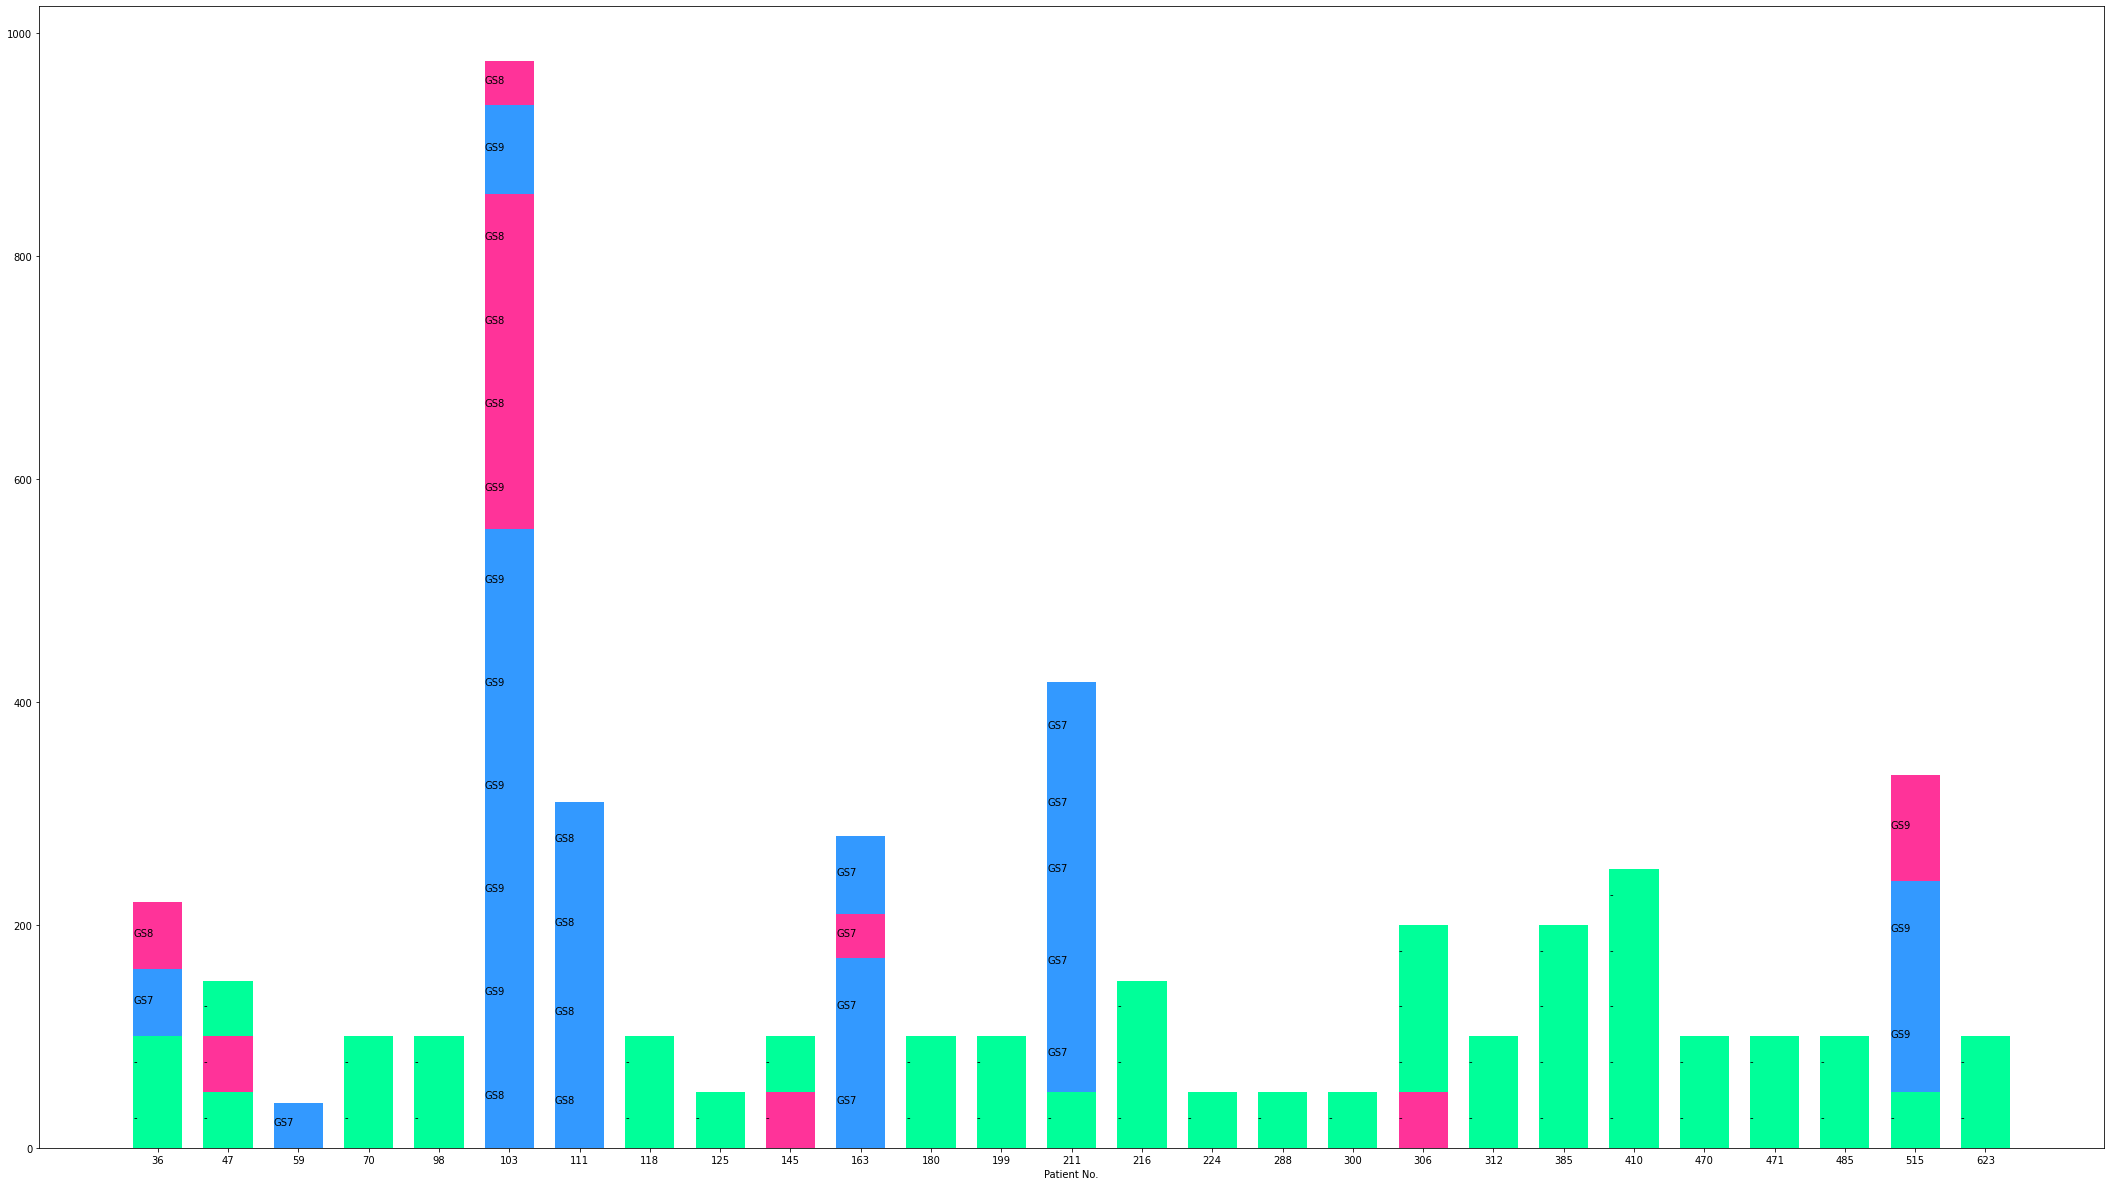

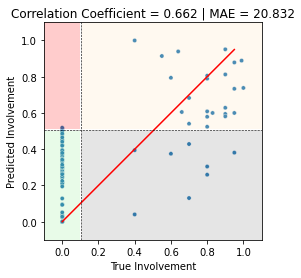

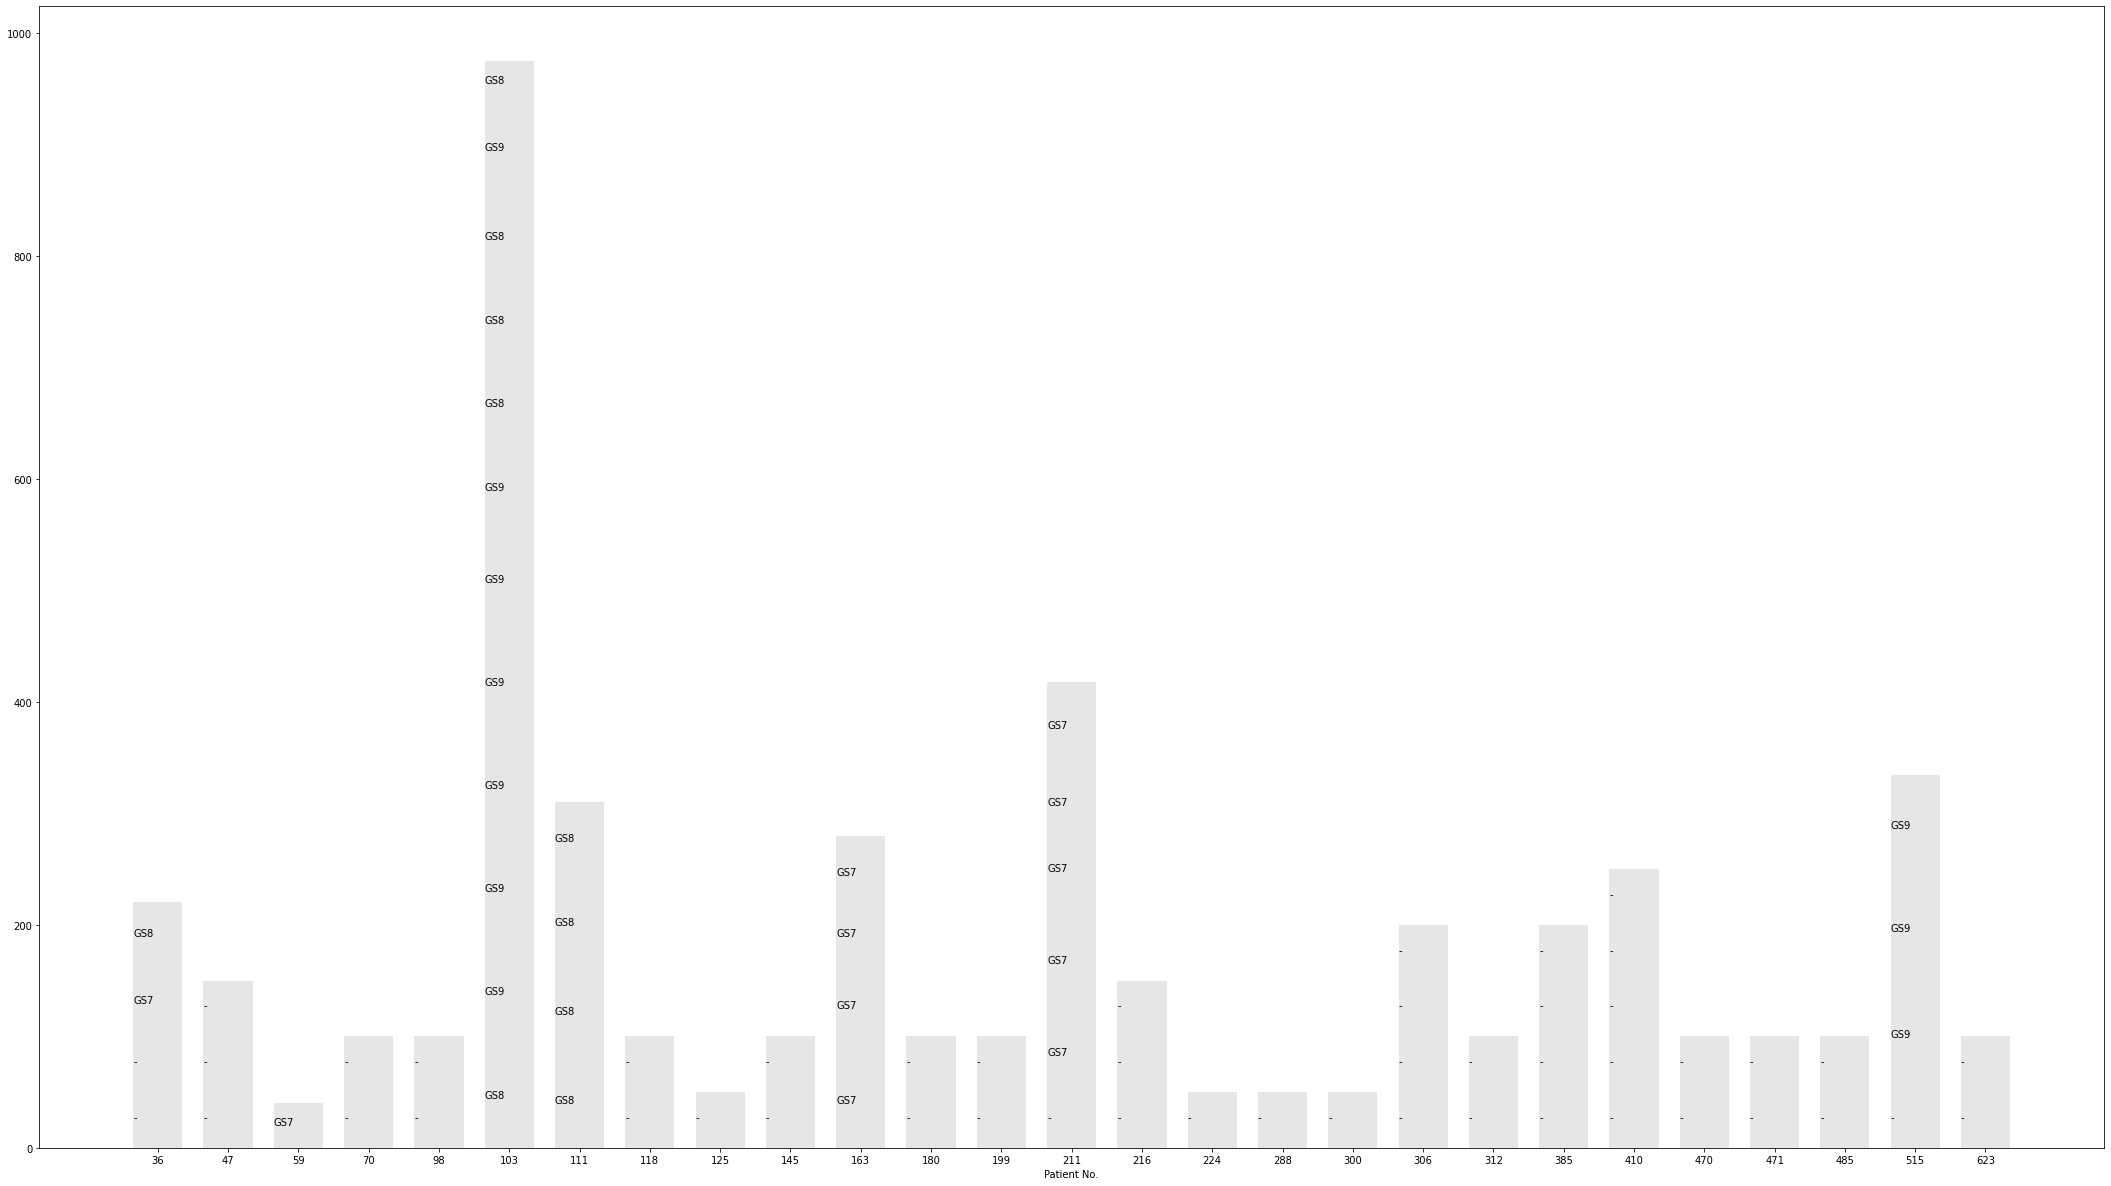

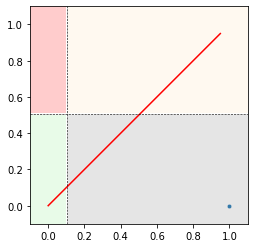

In [33]:
opt.core_th = 0.5
predicted_involvement, ood, prediction_maps = infer_core_wise2(predictions, uncertainty, core_len, roi_coors,
                                                               unc_thr, ood_scores)
scores = {'acc_s': acc_s, 'acc_sb': acc_sb}
if opt.loss_name == 'edl' or opt.dropout.rate!='none':
    scores['acc_sb-unc'] = acc_sb_unc

scores = compute_metrics(predicted_involvement, true_involvement,
                             current_epoch=0, verbose=True, scores=scores,
                             threshold=opt.core_th, edl=True)

net_interpretation2(predicted_involvement, patient_id_bk,
                   true_involvement, gs_bk, opt.paths.result_dir,
                   ood=ood, current_epoch=0, set_name=state,
                   writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)

In [34]:
ind = np.array(input_data[f'inv_{state}']>=.4) | np.array(input_data[f'inv_{state}']==0)
print((np.unique(input_data[f'PatientId_{state}'][ind])).astype(int))

[ 36  47  59  70  98 103 111 118 125 145 163 180 199 211 216 224 288 300
 306 312 385 410 470 471 485 515 623]


In [122]:
all_accb=[]
all_accb_unc=[]
all_accsb_unc=[]

In [126]:
# for seed in [0,5, 10]:
##todo dropout
for srs in [26,30]:
    for seed in [0, 5, 10, 15]:
        accb_unc=[]
        accsb_unc=[]
        project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
        args = {}
        args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
        # args['exp_suffix'] = f'_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs{srs}_vs.25_edl-thr.2crr_sd{seed}_ep200'
        ##todo dropout
        args['exp_suffix'] = f'_mskedPatch/crrt-ds-splt--_res10_srs{srs}_vs.25_ce-thr.1-drp.1-30_sd{seed}_invl1val15tst_ep200'
        with open(args['config']) as f:
            opt = yaml.load(f, Loader)
        opt.update(args)
        opt = munchify(opt)
        opt.project_root = project_root
        opt = setup_directories(opt)
        opt.core_th = 0.5
        ##todo dropout
        opt.loss_name = 'ce'
        opt.dropout.rate = 0.1

        net = construct_network(device, opt)
        net = net[0]()
        suffix = '_1'
        try:
            net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))
        except:
            continue
        print("srs and seed:",srs, seed)

        arr = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
        # arr = [1., 0.5, 0.3, 0.2, 0.15, 0.1, 0.075, 0.05,0.025]
        for thr in arr:
            ##todo dropout
            predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc = predict(net, x_data, y_label, device, 'dropout', unc_thr=thr)
            predicted_involvement, ood, prediction_maps = infer_core_wise2(predictions, uncertainty, core_len, roi_coors, thr, ood_scores)
            scores = {'acc_s': acc_s, 'acc_sb': acc_sb,'acc_sb-unc':acc_sb_unc}
            scores = compute_metrics(predicted_involvement, true_involvement, current_epoch=0, verbose=False, scores=scores,
                                     threshold=opt.core_th, edl=True)
            # net_interpretation2(predicted_involvement, patient_id_bk, true_involvement, gs_bk, opt.paths.result_dir, ood=ood,
            #                     current_epoch=0, set_name=state, writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)
            accb_unc.append(scores['acc_b-uncrtan'])
            accsb_unc.append(scores['acc_sb-unc'])
        print(accb_unc)
        all_accb_unc.append(accb_unc)
        all_accsb_unc.append(accsb_unc)

srs and seed: 26 0
no batches and batch size: 43 64


KeyboardInterrupt: 

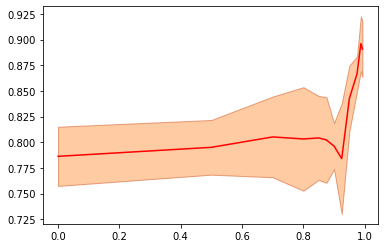

In [124]:
# all_accb_unc = [all_accb_unc[i] for i in [12, 13, 14]]
# all_accsb_unc = [all_accsb_unc[i] for i in [12, 13, 14]]
acc_b_stack = np.stack(all_accb_unc, axis=0)
acc_b_mean = np.mean(acc_b_stack, axis=0)
acc_b_std = np.sqrt(np.var(acc_b_stack, axis=0))
fig1, ax1 = plt.subplots()
# fig1.set_size_inches(18.5, 10.5)
x = 1-np.array(arr)
ax1.plot(x, acc_b_mean, 'r-')
plt.fill_between(x, acc_b_mean-acc_b_std, acc_b_mean+acc_b_std,
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.show()

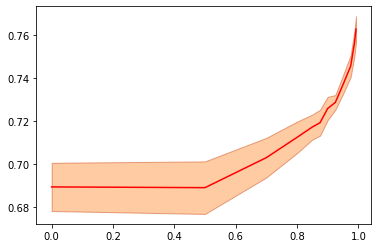

In [125]:
acc_sb_stack = np.stack(all_accsb_unc, axis=0)
acc_sb_mean = np.mean(acc_sb_stack, axis=0)
acc_sb_std = np.sqrt(np.var(acc_sb_stack, axis=0))
fig1, ax1 = plt.subplots()
# fig1.set_size_inches(18.5, 10.5)
x = 1-np.array(arr)
ax1.plot(x, acc_sb_mean, 'r-')
plt.fill_between(x, acc_sb_mean-acc_sb_std, acc_sb_mean+acc_sb_std,
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.show()

In [17]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from matplotlib.colors import NoNorm
# from einops import rearrange
#
# needle = mpimg.imread('../needle.png')
#
# # needle = rearrange(needle, 'h w c -> c h w')
# # needle = (needle - np.mean(needle, axis=(0,1)))
# plt.imshow(needle, norm=NoNorm())
# plt.show()
#
# img = x_data[0,...]
# img = rearrange(img, 'c h w -> h w c')
#
# img_label = y_label[0,...]
# img_prediction = predictions[0,...]
#
#
# plt.imshow(img,cmap='gray',norm=NoNorm())
# plt.show()

In [12]:
# needle2 = needle[:,:,0]
# pred_needle = np.copy(needle)
# img = np.array(img)
# img2 = img[::4,::4]
# img_h = img2.shape[0]
# img_w = img2.shape[1]
# img_fake = np.ones_like(img2[:,:,0])
# pred_needle[376-img_h:376, 402:402+img_w, 0] += img_fake#
#
#
# plt.figure(figsize=(18.5, 10.5))
# plt.imshow(pred_needle, norm=NoNorm())
# plt.show()

In [ ]:
def pred_colormap(needle_img, img, pred, patient, inv, pred_inv, gs):
    import matplotlib.pyplot as plt
    from matplotlib.colors import NoNorm
    from einops import rearrange

    pred_needle = np.copy(needle_img)
    # with or without backgroubd? Comment it and see
    pred_needle[:,:,0:3] = np.zeros_like(pred_needle[:,:,0:3])

    img = np.array(img)
    img = rearrange(img, 'b c h w -> b h w c')
    scale = 4
    img2 = img[:,::scale,::scale,:]

    no_patches = img2.shape[0]
    img_h = img2.shape[1]
    img_w = img2.shape[2]
    tip_x = 376
    tip_y = 402

    img_fake = np.ones_like(img2)
    for i in range(no_patches):
        # if i%4==0:
            img_pred = 1 if int((pred[i,1]<=0.5)) else 0
            intensity = 1*((pred[i,0] if img_pred==1 else pred[i,1]) - 0.5)

            x_pos = tip_x - i*int(19/scale)
            y_pose = tip_y + i*int(25/scale)
            pred_needle[x_pos - img_h:x_pos, y_pose:y_pose + img_w, img_pred] += intensity*img_fake[i,:,:,0] #10*img2[i,:,:,0]

    fig = plt.figure(figsize=(18.5, 10.5))
    ax = fig.add_subplot()
    ax.text(80, 60, f'Patient:{int(patient)}  '+f'Inv:{inv}  '+f'PredInv:{pred_inv:.3}  '+f'GS:{gs}',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, fontsize=30)
    plt.imshow(pred_needle, norm=NoNorm())
    plt.show()

    return pred_needle

In [ ]:
import matplotlib.image as mpimg
needle = mpimg.imread('../needle.png')
core_cumsum = np.cumsum(core_len)
indx, = np.where(patient_id_bk==36)
for j in indx:
    print('Patient:', int(patient_id_bk[j]), 'Inv:', true_involvement[j], f'Pred:{predicted_involvement[j]:.3}')
    start = 0 if j==0 else core_cumsum[j-1]
    end = core_cumsum[j]
    pred_colormap(needle, x_data[start:end,...], predictions[start:end,...],
                  patient_id_bk[j], true_involvement[j], predicted_involvement[j], gs_bk[j])